## Importing libraries

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
from collections import Counter


## Defining helper functions: 

In [98]:
def read_data_file(filepath='dtrain123.dat'):
    """
    This function reads the data from the specified file.

    INPUT:
        filepath (str): 
            Path to the data file.

    OUTPUT:
        dataset (ndarray): 
            Numpy array of shape (num_samples, 257) containing the loaded data.
    """
    return np.loadtxt(filepath, usecols=range(257))

def split_data(dataset):
    """
    This function shuffles the dataset and splits it into 80% training and 20% testing.

    INPUT:
        dataset (ndarray): 
            Array of shape (num_samples, 257), where the first column is a label.

    OUTPUT:
        training_subset (ndarray): 
            2D array containing ~80% of the original dataset as training data.
        testing_subset (ndarray): 
            2D array containing the remaining ~20% of the dataset as testing data.
    """
    np.random.shuffle(dataset)
    split_pt = int(0.8 * len(dataset))
    training_subset = dataset[:split_pt, :]
    testing_subset = dataset[split_pt:, :]
    return training_subset, testing_subset

def extract_labels(dataset):
    """
    This function extracts the digit labels from the dataset.

    INPUT:
        dataset (ndarray): 
            Array of shape (num_samples, 257) where the first column is a label.

    OUTPUT:
        label_array (ndarray): 
            1D array of shape (num_samples,) containing integer labels (0 to 9).
    """
    return dataset[:, 0].astype(int)

def extract_images(dataset):
    """
    This function extracts the pixel information (columns 1 to 256) from the dataset.

    INPUT:
        dataset (ndarray): 
            Array of shape (num_samples, 257).

    OUTPUT:
        image_data (ndarray): 
            Array of shape (num_samples, 256) representing flattened 16x16 images.
    """
    return dataset[:, 1:].astype(int)

def initialize_classifier(data_array):
    """
    This function initialises the classifier weights for One-vs-Rest.

    INPUT:
        data_array (ndarray): 
            The training data array of shape (num_samples, 257).

    OUTPUT:
        classifier_array (ndarray): 
            2D array of shape (num_samples, 10) for the OVR weights.
    """
    return np.zeros((data_array.shape[0], 10))

def transform_labels(label_vector):
    """
    This function converts integer labels (0 to 9) into a One-vs-Rest format {+1, -1}.

    INPUT:
        label_vector (ndarray): 
            1D array of shape (num_samples,) with integer labels in {0 to 9}.

    OUTPUT:
        output_array (ndarray): 
            2D array of shape (num_samples, 10). 
            Each row has +1 for the corresponding digit and -1 otherwise.
    """
    num_samples = label_vector.shape[0]
    output_array = -np.ones((num_samples, 10), dtype=int)
    for i, label in enumerate(label_vector):
        output_array[i, label] = 1
    return output_array


def predict_classifier(k_eval, classifier_array):
    """
    This function computes the raw decision scores for each class given kernel evaluations.

    INPUT:
        k_eval (ndarray): 
            1D array of kernel evaluations between a single test sample and all training samples 
            (shape: (num_train,)).
        classifier_array (ndarray): 
            2D array of shape (num_train, 10) representing the classifier weights.

    OUTPUT:
        raw_scores (ndarray): 
            1D array of shape (10,) containing the raw decision scores for each of the 10 classes.
    """
    return np.dot(classifier_array.T, k_eval)

def sign_preds(raw_scores):
    """
    This function applies the sign operation to raw scores.

    INPUT:
        raw_scores (ndarray): 
            1D array or scalar representing decision function values.

    OUTPUT:
        signs (ndarray): 
            Array of +1 or -1 values, matching the shape of raw_scores.
    """
    return np.where(raw_scores <= 0, -1, 1)

def average_and_sd(value_array):
    """
    This function computes the mean and standard deviation of the input array.

    INPUT:
        value_array (ndarray): 
            1D or 2D array of numeric values.

    OUTPUT:
        mean_val (float): 
            Mean of the array.
        std_val (float): 
            Standard deviation of the array.
    """
    return np.mean(value_array), np.std(value_array)

def compute_error(pred_label, true_label):
    """
    This function calculates the fraction of misclassifications.

    INPUT:
        pred_label (ndarray): 
            1D array of predicted class labels (integers).
        true_label (ndarray): 
            1D array of ground-truth labels (integers).

    OUTPUT:
        error_fraction (float): 
            The ratio (# of incorrect predictions) / (# of total samples).
    """
    incorrect_predictions = np.count_nonzero(pred_label != true_label)
    total_samples = pred_label.size
    error_fraction = incorrect_predictions / total_samples
    return error_fraction


def poly_kernel(p, q, degree):
    """
    This function computes the polynomial kernel (p·q)^degree.

    INPUT:
        p (ndarray): 
            Array of shape (N, 257) with N samples.
        q (ndarray): 
            Array of shape (M, 257) with M samples.
        degree (int): 
            Polynomial degree for the kernel.

    OUTPUT:
        kernel_matrix (ndarray): 
            2D array of shape (N, M) with polynomial kernel evaluations.
    """
    pq_product = np.matmul(p[:, 1:], q[:, 1:].T)
    kernel_matrix = np.power(pq_product, degree)
    return kernel_matrix

def rbf_kernel(p, q, c): 
    """
    This function computes the Gaussian RBF kernel using exp(-c * ||p - q||^2).

    INPUT:
        p (ndarray): 
            Array of shape (N, 257) with N samples.
        q (ndarray): 
            Array of shape (M, 257) with M samples.
        c (float): 
            RBF parameter controlling the width of the Gaussian.

    OUTPUT:
        kernel_matrix (ndarray): 
            2D array of shape (N, M) with RBF kernel evaluations.
    """
    diff = p[:, 1:][:, None, :] - q[:, 1:]
    pairwise_sq_dist = np.sum(diff**2, axis=2)
    kernel_matrix = np.exp(-c * pairwise_sq_dist)
    return kernel_matrix


In [100]:
# We load in the data for the rest of the notebook 
combo_data = read_data_file()

## Question 2

In [101]:
# OVR Training & Testing Routines

def ovr_train_epoch(training_set, classifier_array, kernel_vals):
    """
    This function performs one epoch of One-vs-Rest training with a kernel-based perceptron.

    INPUT:
        training_set (ndarray): 
            Training data of shape (num_samples, 257).
        classifier_array (ndarray): 
            Current classifier weights of shape (num_samples, 10).
        kernel_vals (ndarray): 
            Precomputed kernel values between all training samples, 
            shape (num_samples, num_samples).

    OUTPUT:
        train_error (float): 
            The training misclassification error (fraction).
        updated_classifier (ndarray): 
            The updated classifier array after one epoch of training, shape (num_samples, 10).
    """
    true_label_vec = extract_labels(training_set)
    labels_ovr = transform_labels(true_label_vec)
    predicted_labels = np.zeros(training_set.shape[0], dtype=int)

    for idx, sample in enumerate(training_set):
        raw_preds = predict_classifier(kernel_vals[idx], classifier_array)
        predicted_labels[idx] = np.argmax(raw_preds)
        for k in range(10):
            if labels_ovr[idx, k] * raw_preds[k] <= 0:
                classifier_array[:, k] += labels_ovr[idx, k] * kernel_vals[idx]

    train_error = compute_error(predicted_labels, true_label_vec)
    return train_error, classifier_array

def ovr_test_epoch(train_data, test_data, classifier_array, d_param): 
    """
    This function tests an OVR classifier on a given test set.

    INPUT:
        train_data (ndarray): 
            Training set used to create classifier_array, shape (num_samples, 257).
        test_data (ndarray): 
            Test set for evaluation, shape (test_samples, 257).
        classifier_array (ndarray): 
            The trained classifier weights, shape (num_samples, 10).
        d_param (float or int): 
            Parameter for the kernel (degree if polynomial, c if RBF).

    OUTPUT:
        test_error_val (float): 
            Fraction of misclassified test samples.
        preds (ndarray): 
            1D array of shape (test_samples,) with predicted class labels.
    """
    test_labels = extract_labels(test_data)
    test_k = poly_kernel(test_data, train_data, d_param)

    score_matrix = np.dot(test_k, classifier_array)
    preds = np.argmax(score_matrix, axis=1)

    test_error_val = compute_error(preds, test_labels)
    return test_error_val, preds

def ovr_full_training(train_data, test_data, kernel_vals, d_param):
    """
    This function runs multiple OVR training epochs on the training data and tests on the test data.

    INPUT:
        train_data (ndarray): 
            Training subset of shape (num_samples, 257).
        test_data (ndarray): 
            Testing subset of shape (test_samples, 257).
        kernel_vals (ndarray): 
            Precomputed kernel matrix for training (shape: (num_samples, num_samples)).
        d_param (float or int): 
            Parameter for the kernel.

    OUTPUT:
        final_train_err (float): 
            Training error after the final epoch.
        final_test_err (float): 
            Testing error after training is completed.
        final_preds (ndarray): 
            1D array of shape (test_samples,) containing final predicted labels.
    """
    c_arr = initialize_classifier(train_data)

    for epoch in range(13):
        train_err, c_arr = ovr_train_epoch(train_data, c_arr, kernel_vals)

    test_err, preds = ovr_test_epoch(train_data, test_data, c_arr, d_param)
    return train_err, test_err, preds


In [102]:
# Tests to find the optimal number of epochs

def epoch_training_experiment(data, d_param):
    """
    This function trains an OVR classifier for 20 epochs and tracks the error each epoch.

    INPUT:
        data (ndarray): 
            Full dataset (shape: (num_samples, 207)).
        d_param (int or float): 
            Kernel parameter (degree if polynomial, c if RBF).

    OUTPUT:
        testing_curve (list): 
            List of length 20 containing testing errors at each epoch.
        training_curve (list): 
            List of length 20 containing training errors at each epoch.
    """
    train_block, test_block = split_data(data)

    kernel_func = lambda x, y: poly_kernel(x, y, d_param) 
    train_kernel = kernel_func(train_block, train_block)

    classifier_obj = initialize_classifier(train_block)
    
    def process_epoch(epoch_idx, classifier, train_ker):
        train_error, updated_classifier = ovr_train_epoch(train_block, classifier, train_ker)
        test_error, _ = ovr_test_epoch(train_block, test_block, updated_classifier, d_param)
        return train_error, test_error, updated_classifier

    results = [process_epoch(epoch, classifier_obj, train_kernel) for epoch in range(20)]
    
    training_curve, testing_curve = zip(*[(train_err, test_err) for train_err, test_err, _ in results])
    return list(testing_curve), list(training_curve)

def run_epoch_sweeps(dataset):
    """
    This function performs epoch-based experiments over d = 1 to 7.

    INPUT:
        dataset (ndarray): 
            Full dataset to be split into train/test each run.

    OUTPUT:
        test_collector (list): 
            List of length 7, each element is an array of test errors over 20 epochs.
        train_collector (list): 
            List of length 7, each element is an array of train errors over 20 epochs.
    """
    def collect_errors_for_degree(degree):
        errors = [epoch_training_experiment(dataset, degree) for _ in range(20)]
        test_errs, train_errs = zip(*errors)
        return np.mean(test_errs, axis=0) * 100, np.mean(train_errs, axis=0) * 100

    test_collector, train_collector = zip(*[collect_errors_for_degree(d) for d in range(1, 8)])
    return list(test_collector), list(train_collector)

def plot_epoch_curves(error_arrays, curve_title):
    """
    This function plots error progression over 20 epochs for different kernel parameters.

    INPUT:
        error_arrays (list): 
            Each element corresponds to a parameter setting (e.g., d = 1 to 7). 
            Each element is an array of length 20 with the recorded errors.
        curve_title (str): 
            Title prefix for the plot (e.g., "Training" or "Testing").

    OUTPUT:
        None (displays a plot).
    """
    plt.style.use('dark_background') 
    fig, ax = plt.subplots(figsize=(8, 6))
    color_cycle = plt.cm.viridis(np.linspace(0, 1, len(error_arrays)))
    for idx, (err_vals, color) in enumerate(zip(error_arrays, color_cycle)):
        ax.plot(
            range(1, 21),
            err_vals,
            marker='o',
            markersize=6, 
            linewidth=2, 
            color=color,
            label=f'd = {idx+1}'
        )
    ax.set_xticks(range(1, 21))
    ax.set_xlabel('Epoch', fontsize=12, fontweight='bold', color='white')
    ax.set_ylabel(curve_title + ' Error %', fontsize=12, fontweight='bold', color='white')
    ax.set_title(f'{curve_title} Error vs. Epochs', fontsize=14, fontweight='bold', color='white')
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
    ax.legend(loc='best', frameon=True)
    plt.show()

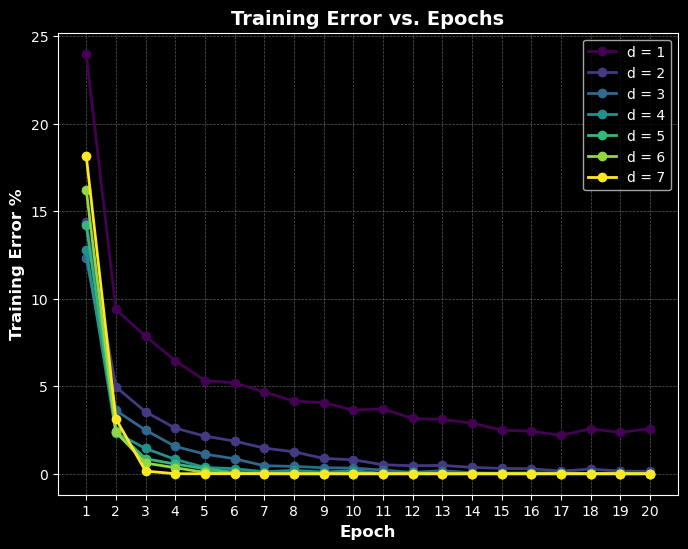

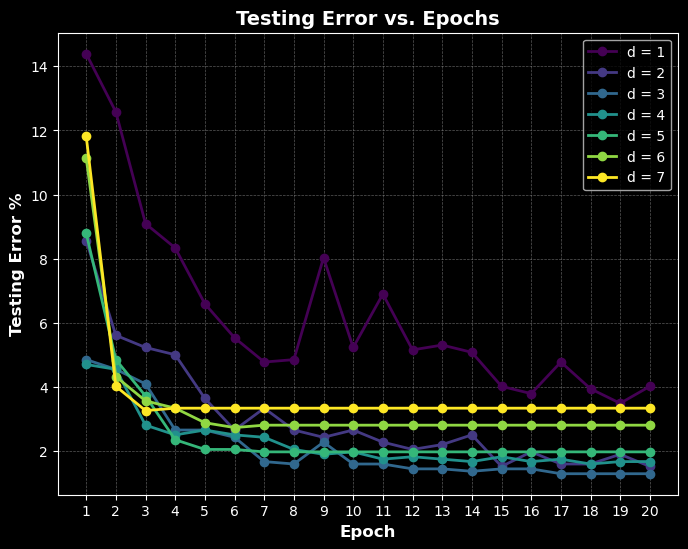

In [103]:
# We obtain and plot the training and testing errors
test_errors, train_errors = run_epoch_sweeps(combo_data)
plot_epoch_curves(train_errors, "Training")
plot_epoch_curves(test_errors, "Testing")

## Question 3 - Basic results

In [104]:
def basic_run_model(data_block):
    """
    This function tests polynomial kernel parameters for OVR.

    INPUT:
        data_block (ndarray): 
            Complete dataset (num_samples, 257).

    OUTPUT:
        None (prints summary of train/test errors).
    """
    print("Summary of Mean Errors with Std Deviation (Polynomial Kernel)\n")

    def compute_errors(tr_block, te_block, param_val):
        train_kernel = poly_kernel(tr_block, tr_block, param_val)
        return ovr_full_training(tr_block, te_block, train_kernel, param_val)[:2]

    param_range = np.linspace(1, 7, 7)

    for val in param_range:
        train_res, test_res = zip(*[
            compute_errors(*split_data(data_block), val) for _ in range(20)
        ])

        mu_tr, sd_tr = average_and_sd(np.array(train_res))
        mu_te, sd_te = average_and_sd(np.array(test_res))

        print(f"d = {val}")
        print(f"Training: {mu_tr*100:.2f}% ± {sd_tr*100:.2f}%")
        print(f"Testing:  {mu_te*100:.2f}% ± {sd_te*100:.2f}%\n")


In [105]:
basic_run_model(combo_data)

Summary of Mean Errors with Std Deviation (Polynomial Kernel)

d = 1.0
Training: 3.75% ± 0.88%
Testing:  5.98% ± 10.84%

d = 2.0
Training: 0.89% ± 0.59%
Testing:  2.05% ± 1.68%

d = 3.0
Training: 0.06% ± 0.14%
Testing:  0.91% ± 1.01%

d = 4.0
Training: 0.00% ± 0.00%
Testing:  1.59% ± 1.31%

d = 5.0
Training: 0.00% ± 0.00%
Testing:  1.44% ± 1.88%

d = 6.0
Training: 0.00% ± 0.00%
Testing:  2.73% ± 1.95%

d = 7.0
Training: 0.00% ± 0.00%
Testing:  3.79% ± 2.89%



## Question 4 - Cross-validation

In [106]:
def partition_fold(data_fold, k_idx):
    """
    This function partitions the dataset into a training and validation fold.

    INPUT:
        data_fold (ndarray): 
            Data array for cross-validation (shape: (num_samples, 257)).
        k_idx (int): 
            Fold index to select (0 to 4 for 5-folds).

    OUTPUT:
        train_portion (ndarray): 
            Training fold consisting of all but one fold.
        val_portion (ndarray): 
            Validation fold (1/5 of the data).
    """
    block_size = len(data_fold) // 5
    indices = np.arange(len(data_fold))
    val_indices = indices[k_idx * block_size : (k_idx + 1) * block_size]
    train_indices = np.setdiff1d(indices, val_indices)

    val_portion = data_fold[val_indices]
    train_portion = data_fold[train_indices]

    return train_portion, val_portion

def one_run_train_test(train_subset, test_subset, d_hyp):
    """
    This function trains on one subset using a polynomial kernel, then tests on another subset.

    INPUT:
        train_subset (ndarray): 
            Training data, shape (train_samples, 257).
        test_subset (ndarray): 
            Testing data, shape (test_samples, 257).
        d_hyp (float or int): 
            Kernel hyperparameter (degree).

    OUTPUT:
        tr_e (float): 
            Training error after the final epoch.
        te_e (float): 
            Testing error on the provided test subset.
        pr (ndarray): 
            Predictions for the test subset, shape (test_samples,).
    """
    k_train = poly_kernel(train_subset, train_subset, d_hyp)
    tr_e, te_e, pr = ovr_full_training(train_subset, test_subset, k_train, d_hyp)
    return tr_e, te_e, pr

def cross_validate(train_set):
    """
    This function performs 5-fold cross-validation on a training set for polynomial kernels.

    INPUT:
        train_set (ndarray): 
            Training portion of the data (80% split).

    OUTPUT:
        avg_test_errs (ndarray): 
            1D array of mean test errors for each parameter across folds.
        param_space (ndarray): 
            1D array of the parameter values tested.
    """
    param_space = np.linspace(1, 7, 7)
    fold_errors = np.zeros((5, len(param_space)))

    for fold_idx in range(5):
        sub_train, sub_val = partition_fold(train_set, fold_idx)
        for param_idx, param_item in enumerate(param_space):
            _, err_val, _ = one_run_train_test(sub_train, sub_val, param_item)
            fold_errors[fold_idx, param_idx] = err_val

    avg_test_errs = fold_errors.mean(axis=0)
    return avg_test_errs, param_space

def pick_best_param(errors_arr, param_arr):
    """
    This function picks the parameter value that yields the smallest error.

    INPUT:
        errors_arr (ndarray): 
            1D array of test errors for each parameter.
        param_arr (ndarray): 
            1D array of parameter values tested.

    OUTPUT:
        best_param (float): 
            The parameter value with the minimum test error.
    """
    idx_min = np.argmin(errors_arr)
    return param_arr[idx_min]

def single_cv_run(data_block):
    """
    This function executes a single cross-validation run for polynomial kernels.

    INPUT:
        data_block (ndarray): 
            Full dataset to be split (num_samples, 257).

    OUTPUT:
        final_tr_err (float): 
            Training error after final retrain.
        final_te_err (float): 
            Testing error on hold-out set.
        chosen_param (float): 
            Parameter value selected by CV.
        te_split (ndarray): 
            The hold-out test set used for final testing.
        preds_out (ndarray): 
            Final predictions on the hold-out test set.
    """
    tr_split, te_split = split_data(data_block)
    val_errs, param_vals = cross_validate(tr_split)
    chosen_param = pick_best_param(val_errs, param_vals)

    final_tr_err, final_te_err, preds_out = one_run_train_test(
        tr_split, te_split, chosen_param
    )

    return final_tr_err, final_te_err, chosen_param, te_split, preds_out

def run_cv_experiments(data_block):
    """
    This function repeats cross-validation experiments 20 times for polynomial kernels.

    INPUT:
        data_block (ndarray): 
            Full dataset.

    OUTPUT:
        test_error_list (list): 
            List of test errors (length=20) after final model evaluation.
        chosen_param_list (list): 
            List of chosen parameters (length=20) from cross-validation.
    """
    results = [single_cv_run(data_block) for _ in range(20)]

    test_error_list = [res[1] for res in results]
    chosen_param_list = [res[2] for res in results]
    train_error_list = [res[0] for res in results]

    avg_test, sd_test = average_and_sd(test_error_list)
    avg_param, sd_param = average_and_sd(chosen_param_list)
    avg_train, sd_train = average_and_sd(train_error_list)

    print(f"Best d*: {avg_param:.2f} ± {sd_param:.2f}")
    print(f"Train Error : {avg_train*100:.2f}% ± {sd_train*100:.2f}%")
    print(f"Test  Error : {avg_test*100:.2f}% ± {sd_test*100:.2f}%")

    return test_error_list, chosen_param_list

In [107]:
run_cv_experiments(combo_data)

Best d*: 3.05 ± 0.67
Train Error : 0.11% ± 0.30%
Test  Error : 1.82% ± 1.70%


([0.0,
  0.0,
  0.015151515151515152,
  0.030303030303030304,
  0.0,
  0.015151515151515152,
  0.0,
  0.030303030303030304,
  0.015151515151515152,
  0.0,
  0.015151515151515152,
  0.0,
  0.030303030303030304,
  0.0,
  0.06060606060606061,
  0.015151515151515152,
  0.030303030303030304,
  0.030303030303030304,
  0.030303030303030304,
  0.045454545454545456],
 [3.0,
  2.0,
  4.0,
  3.0,
  4.0,
  3.0,
  3.0,
  2.0,
  4.0,
  4.0,
  2.0,
  3.0,
  3.0,
  4.0,
  3.0,
  3.0,
  2.0,
  3.0,
  3.0,
  3.0])

## Question 5 - Confusion Matrix

In [108]:
def tally_confusions(real_vals, predicted_vals):
    """
    This function accumulates confusion counts: how many times a digit a 
    was predicted as b.

    INPUT:
        real_vals (ndarray): 
            1D array of ground-truth labels (shape: (num_test_samples,)).
        predicted_vals (ndarray): 
            1D array of predicted labels (same length as real_vals).

    OUTPUT:
        matrix_counts (ndarray): 
            2D array of shape (10, 10) with counts of misclassifications 
            (off-diagonal entries).
    """
    matrix_counts = np.zeros((10, 10), dtype=int)
    indices = (real_vals != predicted_vals)
    np.add.at(matrix_counts, (real_vals[indices], predicted_vals[indices]), 1)
    return matrix_counts

def compute_rates_across_runs(conf_list, digit_counts):
    """
    This function converts confusion counts into error rates per digit.

    INPUT:
        conf_list (ndarray): 
            3D array of shape (runs, 10, 10) with confusion counts for each run.
        digit_counts (ndarray): 
            2D array of shape (runs, 10) with number of times each digit appears.

    OUTPUT:
        avg_conf_matrix (ndarray): 
            2D array of shape (10, 10) with average error rates across runs.
        sd_conf_matrix (ndarray): 
            2D array of shape (10, 10) with std of error rates across runs.
    """
    with np.errstate(divide='ignore', invalid='ignore'):
        rate_list = np.where(digit_counts[:, :, None] > 0, conf_list / digit_counts[:, :, None], 0.0)
    return rate_list.mean(axis=0), rate_list.std(axis=0)

def gather_confusions_over_runs(data_block):
    """
    This function runs cross-validation experiments 20 times, 
    picking the best kernel parameter each time, and accumulates confusion counts.

    INPUT:
        data_block (ndarray): 
            Full dataset to be tested (num_samples, 257).

    OUTPUT:
        avg_conf_matrix (ndarray): 
            2D array (10, 10) of mean confusion rates across 20 runs.
        sd_conf_matrix (ndarray): 
            2D array (10, 10) of std confusion rates across 20 runs.
    """
    conf_arrays = []
    digit_sums = []

    for _ in range(20):
        tr_e, te_e, chosen_d, test_partition, test_preds = single_cv_run(
            data_block)
        real_test_lbls = extract_labels(test_partition)

        conf_mat = tally_confusions(real_test_lbls, test_preds)
        conf_arrays.append(conf_mat)

        digit_count = np.bincount(real_test_lbls, minlength=10)
        digit_sums.append(digit_count)

    conf_arrays = np.array(conf_arrays)
    digit_sums = np.array(digit_sums)

    avg_conf_matrix, sd_conf_matrix = compute_rates_across_runs(conf_arrays, digit_sums)
    return avg_conf_matrix, sd_conf_matrix

def display_confusion_matrix(avg_mat, sd_mat):
    """
    This function neatly displays a 10x10 confusion matrix with 
    mean ± std in each cell.

    INPUT:
        avg_mat (ndarray): 
            2D array (10, 10) of mean confusion rates.
        sd_mat (ndarray): 
            2D array (10, 10) of standard deviations of confusion rates.

    OUTPUT:
        None (prints matrix to console).
    """
    for row_idx in range(10):
        row_entries = []
        for col_idx in range(10):
            row_entries.append(f"{avg_mat[row_idx,col_idx]:.3f}±{sd_mat[row_idx,col_idx]:.3f}")
        print("  ".join(row_entries))
    print()

def plot_confusion_matrix(avg_mat, sd_mat):
    """
    This function displays a confusion matrix as a heatmap with mean ± std values.

    INPUT:
        avg_mat (ndarray): 2D array (10, 10) of mean confusion rates.
        sd_mat (ndarray): 2D array (10, 10) of standard deviations of confusion rates.

    OUTPUT:
        None (displays the heatmap).
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.matshow(avg_mat, cmap="coolwarm")
    plt.colorbar(cax)

    for (i, j), val in np.ndenumerate(avg_mat):
        std_dev = sd_mat[i, j]
        ax.text(j, i, f"{val:.2f}\n±{std_dev:.2f}", ha="center", va="center", color="black")

    ax.set_xlabel("Predicted Label", fontsize=12)
    ax.set_ylabel("True Label", fontsize=12)
    ax.set_xticks(range(10))
    ax.set_yticks(range(10))
    ax.set_xticklabels(range(10))
    ax.set_yticklabels(range(10))
    plt.title("Confusion Matrix", fontsize=14)
    plt.show()

0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000
0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000
0.000±0.000  0.011±0.023  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000
0.000±0.000  0.011±0.026  0.031±0.050  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000
0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000
0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000
0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000
0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±0.000  0.000±

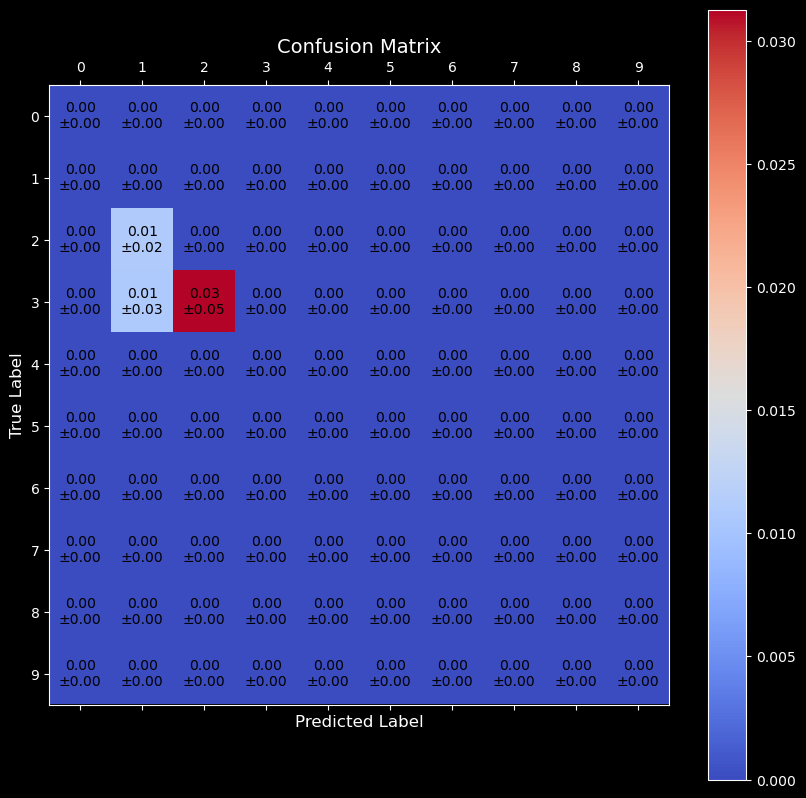

In [109]:
mean_conf, std_conf = gather_confusions_over_runs(combo_data)
display_confusion_matrix(mean_conf, std_conf)
plot_confusion_matrix(mean_conf, std_conf)

## Question 6 - 5 hardest to classsify

Most frequently misclassified images and their labels:
Image 1 True Label: 2


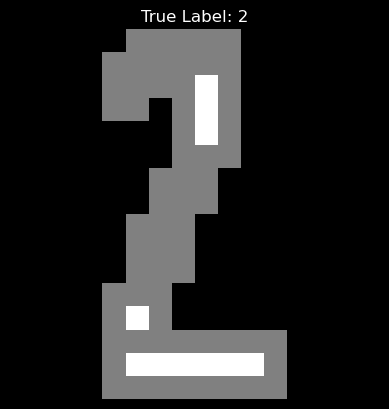

Image 2 True Label: 3


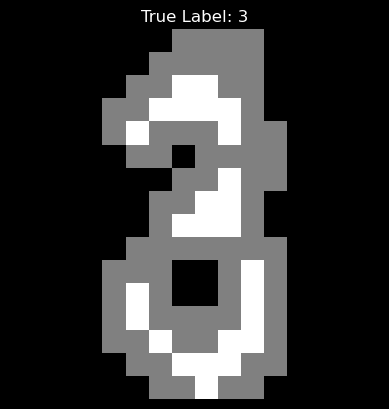

Image 3 True Label: 3


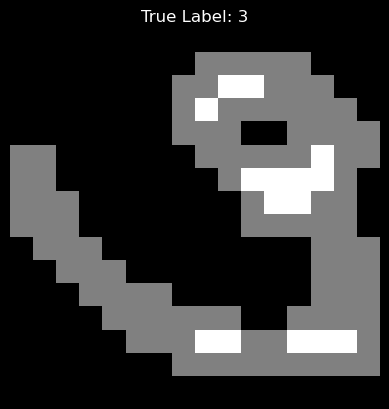

Image 4 True Label: 3


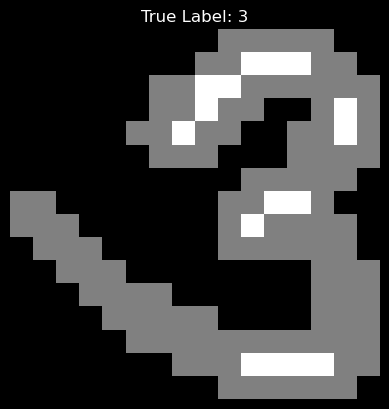

Image 5 True Label: 2


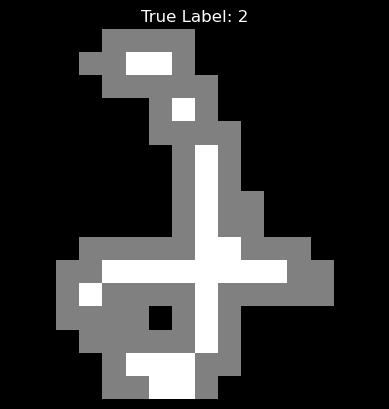

In [110]:
def find_misclassified(true_vals, predicted_vals, image_data):
    """
    Identify misclassified samples along with their true labels and associated image data.

    INPUT:
        true_vals (list or ndarray):
            List or stacked array of true labels from different runs.
        predicted_vals (list or ndarray):
            List or stacked array of predicted labels matching the true labels' format.
        image_data (list or ndarray):
            List or stacked array of flattened image data matching the labels' format.

    OUTPUT:
        misclassified_samples (ndarray):
            Array with each row containing a true label followed by the corresponding
            image data for misclassified samples.
    """
    true_vals_flat = np.ravel(np.array(true_vals))
    predicted_vals_flat = np.ravel(np.array(predicted_vals))
    image_data_flat = np.vstack(image_data)

    error_indices = np.where(true_vals_flat != predicted_vals_flat)[0]

    error_labels = true_vals_flat[error_indices]
    error_images = image_data_flat[error_indices]

    misclassified_samples = np.column_stack((error_labels, error_images))
    return misclassified_samples


def most_frequent_errors(misclassified_samples):
    """
    Identify the 5 most frequently misclassified samples from the misclassified data.

    INPUT:
        misclassified_samples (ndarray):
            Array where the first column contains true labels, and the remaining
            columns contain pixel data for misclassified images.

    OUTPUT:
        frequent_labels (ndarray):
            Array of length 5 with the labels of the most frequently misclassified samples.
        frequent_images (ndarray):
            Array of shape (5, #_pixels) containing the pixel data of these samples.
    """
    structured_data_type = [
        ('true_label', int), 
        ('pixel_data', (misclassified_samples.dtype, misclassified_samples.shape[1] - 1))
    ]
    structured_array = np.array(
        [(row[0], row[1:]) for row in misclassified_samples],
        dtype=structured_data_type
    )

    unique_rows, row_counts = np.unique(structured_array, return_counts=True)

    top_row_indices = np.argsort(row_counts)[-5:]
    top_samples = unique_rows[top_row_indices]

    frequent_labels = np.array([sample['true_label'] for sample in top_samples])
    frequent_images = np.array([sample['pixel_data'] for sample in top_samples])
    return frequent_labels, frequent_images


def get_top_misclassified_from_runs(data_block):
    """
    Identifies the 5 most frequently misclassified images across 20 runs of cross-validation.

    INPUT:
        test_error_list (list): List of test errors for the 20 runs.
        chosen_param_list (list): List of chosen parameters for the 20 runs.
        data_block (ndarray): Complete dataset (num_samples, 257).

    OUTPUT:
        top_labels (ndarray): Labels of the 5 most frequently misclassified images.
        top_images (ndarray): Flattened images of the 5 most frequently misclassified samples.
    """
    all_misclassified = []

    for _ in range(20):
        final_tr_err, final_te_err, chosen_param, te_split, preds_out = single_cv_run(data_block)
        test_labels = extract_labels(te_split)
        test_images = extract_images(te_split)

        miscls_data = find_misclassified([test_labels], [preds_out], [test_images])
        all_misclassified.append(miscls_data)

    all_misclassified = np.concatenate(all_misclassified, axis=0)
    labels, images = most_frequent_errors(all_misclassified)
    return labels, images

top_labels, top_images = get_top_misclassified_from_runs(combo_data)

print("Most frequently misclassified images and their labels:")
for i in range(len(top_labels)):
    print(f"Image {i + 1} True Label: {top_labels[i]}")
    plt.imshow(top_images[i].reshape(16, 16), cmap='gray')
    plt.title(f"True Label: {top_labels[i]}")
    plt.axis('off')
    plt.show()


## Question 7 - Gaussian Kernel 

## 7a - Finding the values for $c$

In [111]:
# Coarse search
def ovr_test_epoch_rbf(train_data, test_data, classifier_array, d_param): 
    """
    This function tests an OVR classifier on a given test set.

    INPUT:
        train_data (ndarray): 
            Training set used to create classifier_array, shape (num_samples, 257).
        test_data (ndarray): 
            Test set for evaluation, shape (test_samples, 257).
        classifier_array (ndarray): 
            The trained classifier weights, shape (num_samples, 10).
        d_param (float or int): 
            Parameter for the kernel (degree if polynomial, c if RBF).

    OUTPUT:
        test_error_val (float): 
            Fraction of misclassified test samples.
        preds (ndarray): 
            1D array of shape (test_samples,) with predicted class labels.
    """
    test_labels = extract_labels(test_data)
    test_k = rbf_kernel(test_data, train_data, d_param)

    if classifier_array.ndim == 1:
        classifier_array = classifier_array.reshape(train_data.shape[0], -1)

    score_matrix = np.dot(test_k, classifier_array)
    preds = np.argmax(score_matrix, axis=1)

    test_error_val = compute_error(preds, test_labels)
    return test_error_val, preds

def ovr_full_training_rbf(train_data, test_data, kernel_vals, d_param):
    """
    This function runs multiple OVR training epochs on the training data and tests on the test data.

    INPUT:
        train_data (ndarray): 
            Training subset of shape (num_samples, 257).
        test_data (ndarray): 
            Testing subset of shape (test_samples, 257).
        kernel_vals (ndarray): 
            Precomputed kernel matrix for training (shape: (num_samples, num_samples)).
        d_param (float or int): 
            Parameter for the kernel (degree or c).

    OUTPUT:
        final_train_err (float): 
            Training error after the final epoch.
        final_test_err (float): 
            Testing error after training is completed.
        final_preds (ndarray): 
            1D array of shape (test_samples,) containing final predicted labels.
    """
    c_arr = initialize_classifier(train_data)

    for epoch in range(13):
        train_err, c_arr = ovr_train_epoch(train_data, c_arr, kernel_vals)

    test_err, preds = ovr_test_epoch_rbf(train_data, test_data, c_arr, d_param)
    
    return train_err, test_err, c_arr

def basic_run_model_rbf(data_block):
    """
    This function tests RBF kernel parameters.

    INPUT:
        data_block (ndarray): 
            Complete dataset (num_samples, 257).

    OUTPUT:
        None (prints summary of train/test errors).
    """
    print("Summary of Mean Errors with Std Deviation (RBF Kernel)\n")

    def compute_errors(tr_block, te_block, param_val):
        """
        Compute training and testing errors for a given parameter value.

        INPUT:
            tr_block (ndarray): Training data.
            te_block (ndarray): Testing data.
            param_val (float): Parameter value for RBF kernel.

        OUTPUT:
            tuple: Training error, Testing error.
        """
        train_kernel = rbf_kernel(tr_block, tr_block, param_val)
        test_kernel  = rbf_kernel(te_block, tr_block, param_val)
        tr_err, te_err, preds = ovr_full_training_rbf(tr_block, te_block, train_kernel, param_val)
        return tr_err, te_err

    for val in param_range:
        train_res, test_res = zip(*[
            compute_errors(*split_data(data_block), val) for _ in range(20)
        ])

        mu_tr, sd_tr = average_and_sd(np.array(train_res))
        mu_te, sd_te = average_and_sd(np.array(test_res))

        print(f"c = {val:.4f}")
        print(f"Training: {mu_tr*100:.2f}% ± {sd_tr*100:.2f}%")
        print(f"Testing:  {mu_te*100:.2f}% ± {sd_te*100:.2f}%\n")

param_range = np.array([0.000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1])
basic_run_model_rbf(combo_data)

Summary of Mean Errors with Std Deviation (RBF Kernel)

c = 0.0000
Training: 65.17% ± 2.74%
Testing:  63.64% ± 8.02%

c = 0.0000
Training: 64.47% ± 3.04%
Testing:  68.94% ± 11.67%

c = 0.0000
Training: 64.05% ± 2.91%
Testing:  63.71% ± 8.96%

c = 0.0001
Training: 59.60% ± 6.97%
Testing:  63.11% ± 10.68%

c = 0.0001
Training: 49.32% ± 11.97%
Testing:  45.83% ± 18.95%

c = 0.0005
Training: 23.14% ± 6.23%
Testing:  32.65% ± 22.05%

c = 0.0010
Training: 14.35% ± 2.52%
Testing:  20.76% ± 14.08%

c = 0.0050
Training: 1.83% ± 0.83%
Testing:  4.09% ± 3.00%

c = 0.0100
Training: 0.02% ± 0.08%
Testing:  1.29% ± 1.10%

c = 0.0500
Training: 0.00% ± 0.00%
Testing:  6.59% ± 3.00%

c = 0.1000
Training: 0.00% ± 0.00%
Testing:  3.71% ± 2.42%

c = 1.0000
Training: 0.00% ± 0.00%
Testing:  3.86% ± 3.16%



In [112]:
# Fine search
param_range = np.array([0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05])
basic_run_model_rbf(combo_data)

Summary of Mean Errors with Std Deviation (RBF Kernel)

c = 0.0050
Training: 1.67% ± 0.73%
Testing:  2.58% ± 2.49%

c = 0.0100
Training: 0.00% ± 0.00%
Testing:  1.14% ± 1.58%

c = 0.0150
Training: 0.00% ± 0.00%
Testing:  1.29% ± 1.38%

c = 0.0200
Training: 0.00% ± 0.00%
Testing:  2.20% ± 2.60%

c = 0.0250
Training: 0.00% ± 0.00%
Testing:  4.09% ± 2.40%

c = 0.0300
Training: 0.00% ± 0.00%
Testing:  5.76% ± 3.02%

c = 0.0350
Training: 0.00% ± 0.00%
Testing:  6.14% ± 4.02%

c = 0.0400
Training: 0.00% ± 0.00%
Testing:  6.14% ± 3.09%

c = 0.0450
Training: 0.00% ± 0.00%
Testing:  8.11% ± 4.85%

c = 0.0500
Training: 0.00% ± 0.00%
Testing:  5.76% ± 3.82%



## 7b - Question 3 procedure with RBF kernel

In [113]:
param_range = np.array([0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016])
basic_run_model_rbf(combo_data)

Summary of Mean Errors with Std Deviation (RBF Kernel)

c = 0.0040
Training: 2.93% ± 0.96%
Testing:  4.17% ± 2.83%

c = 0.0060
Training: 0.80% ± 0.52%
Testing:  2.95% ± 1.88%

c = 0.0080
Training: 0.02% ± 0.08%
Testing:  1.21% ± 1.23%

c = 0.0100
Training: 0.00% ± 0.00%
Testing:  1.82% ± 1.48%

c = 0.0120
Training: 0.00% ± 0.00%
Testing:  1.67% ± 1.72%

c = 0.0140
Training: 0.00% ± 0.00%
Testing:  0.83% ± 1.22%

c = 0.0160
Training: 0.00% ± 0.00%
Testing:  2.05% ± 1.75%



## 7c - Question 4 cross validation procedure with RBF kernel

In [114]:
def one_run_train_test_rbf(train_subset, test_subset, c):
    """
    This function trains on one subset using an RBF kernel, then tests on another subset.

    INPUT:
        train_subset (ndarray): 
            Training data, shape (train_samples, 257).
        test_subset (ndarray): 
            Testing data, shape (test_samples, 257).
        c (float): 
            Kernel hyperparameter (c).

    OUTPUT:
        tr_e (float): 
            Training error after the final epoch.
        te_e (float): 
            Testing error on the provided test subset.
        pr (ndarray): 
            Predictions for the test subset, shape (test_samples,).
    """
    k_train = rbf_kernel(train_subset, train_subset, c)
    tr_e, te_e, classifier_weights = ovr_full_training_rbf(
        train_subset, test_subset, k_train, c
    )
    k_test = rbf_kernel(test_subset, train_subset, c)
    te_e, predictions = ovr_test_epoch_rbf(train_subset, test_subset, classifier_weights, c)
    
    return tr_e, te_e, predictions

def cross_validate_rbf(train_set):
    """
    This function performs 5-fold cross-validation on a training set for RBF kernels.

    INPUT:
        train_set (ndarray): 
            Training portion of the data (80% split).

    OUTPUT:
        avg_test_errs (ndarray): 
            1D array of mean test errors for each parameter across folds.
        param_space (ndarray): 
            1D array of the parameter values tested.
    """
    param_space = np.array([0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016])
    total_test_errs = np.zeros_like(param_space)
    for fold_idx in range(5):
        sub_train, sub_val = partition_fold(train_set, fold_idx)
        val_errs_for_fold = []
        for param_item in param_space:
            _, err_val, _ = one_run_train_test_rbf(sub_train, sub_val, param_item)
            val_errs_for_fold.append(err_val)
        total_test_errs += np.array(val_errs_for_fold)
    return total_test_errs / 5.0, param_space

def single_cv_run_rbf(data_block):
    """
    This function executes a single cross-validation run for RBF kernels.

    INPUT:
        data_block (ndarray): 
            Full dataset to be split (num_samples, 257).

    OUTPUT:
        final_tr_err (float): 
            Training error after final retrain.
        final_te_err (float): 
            Testing error on hold-out set.
        chosen_param (float): 
            Parameter value selected by CV.
        te_split (ndarray): 
            The hold-out test set used for final testing.
        preds_out (ndarray): 
            Final predictions on the hold-out test set.
    """
    tr_split, te_split = split_data(data_block)
    val_errs, param_vals = cross_validate_rbf(tr_split)
    chosen_param = pick_best_param(val_errs, param_vals)
    final_tr_err, final_te_err, preds_out = one_run_train_test_rbf(
        tr_split, te_split, chosen_param)
    return final_tr_err, final_te_err, chosen_param, te_split, preds_out

def run_cv_experiments_rbf(data_block):
    """
    This function repeats cross-validation experiments 20 times for RBF kernels.

    INPUT:
        data_block (ndarray): 
            Full dataset.

    OUTPUT:
        test_error_list (list): 
            List of test errors (length=20) after final model evaluation.
        chosen_param_list (list): 
            List of chosen parameters (length=20) from cross-validation.
    """
    test_error_list = []
    chosen_param_list = []
    train_error_list = []

    for _ in range(20):
        tr_e, te_e, best_p, hold_out_data, predicted_vals = single_cv_run_rbf(data_block)
        test_error_list.append(te_e)
        chosen_param_list.append(best_p)
        train_error_list.append(tr_e)

    avg_test, sd_test = average_and_sd(test_error_list)
    avg_param, sd_param = average_and_sd(chosen_param_list)
    avg_train, sd_train = average_and_sd(train_error_list)

    print(f"Best c*: {avg_param:.2f} ± {sd_param:.2f}")
    print(f"Train Error : {avg_train*100:.2f}% ± {sd_train*100:.2f}%")
    print(f"Test  Error : {avg_test*100:.2f}% ± {sd_test*100:.2f}%")

    return test_error_list, chosen_param_list

run_cv_experiments_rbf(combo_data)

Best c*: 0.01 ± 0.00
Train Error : 0.02% ± 0.08%
Test  Error : 1.82% ± 1.63%


([0.015151515151515152,
  0.0,
  0.030303030303030304,
  0.030303030303030304,
  0.0,
  0.0,
  0.015151515151515152,
  0.015151515151515152,
  0.015151515151515152,
  0.030303030303030304,
  0.0,
  0.030303030303030304,
  0.015151515151515152,
  0.0,
  0.045454545454545456,
  0.030303030303030304,
  0.045454545454545456,
  0.0,
  0.045454545454545456,
  0.0],
 [0.008,
  0.008,
  0.008,
  0.008,
  0.016,
  0.008,
  0.01,
  0.008,
  0.008,
  0.008,
  0.016,
  0.014,
  0.006,
  0.008,
  0.014,
  0.01,
  0.014,
  0.008,
  0.01,
  0.012])

## Question 8 - One-versus-One method

In [115]:
def initialize_classifier_ovo(data):
    """
    This function initializes a One-vs-One (OVO) classifier array.

    INPUT:
        data (ndarray):
            Training data of shape (num_samples, 257). 
            The first column is a label, and the remaining columns are features.

    OUTPUT:
        classifier_ovo (ndarray):
            2D array of shape (num_samples, 45), where 45 = 10*9/2 (all pairwise combinations).
            Each column corresponds to a pairwise classifier's weights for each training sample.
    """
    return np.zeros((data.shape[0], int(10 * 9 / 2)))

def sign_preds(raw_scores):
    """
    This function applies the sign operation to raw scores.

    INPUT:
        raw_scores (ndarray): 
            1D array or scalar representing decision function values.

    OUTPUT:
        signs (ndarray): 
            Array of +1 or -1 values, matching the shape of raw_scores.
    """
    raw_scores = np.array(raw_scores)  
    return np.where(raw_scores <= 0, -1, 1)

def majority_voting(predictions, ovo_pairs): 
    """
    This function performs majority voting given raw predictions for OVO classifiers.
    
    INPUT:
        predictions (ndarray):
            1D array of raw decision scores (length = 45), each score 
            corresponding to one of the 45 OVO pairs.
        ovo_pairs (list of tuples):
            List of all (a, b) digit pairs for OVO.
    
    OUTPUT:
        predicted_class (int):
            The digit (0 to 9) that receives the highest vote count.
    """
    votes = np.zeros(10)
    for idx, pair in enumerate(ovo_pairs):
        winner = pair[int((sign_preds([predictions[idx]])[0] + 1) // 2)]
        votes[winner] += 1

    return np.argmax(votes)

def update_classifier_ovo(sample_index, classifier_weights, predictions, ground_truth, ovo_pairs): 
    """
    Updates the OVO classifier weights for a single training example
    based on whether it was misclassified for each pairwise classifier.
    
    INPUT:
        sample_index (int): Index of the current training example.
        classifier_weights (ndarray): Classifier weight array of shape (num_samples, 45).
        predictions (ndarray): 1D array of length 45 containing raw decision scores for the OVO pairs.
        ground_truth (ndarray): 1D array of integer digit labels (0..9), shape (num_samples,).
        ovo_pairs (list of tuples): List of digit pairs (a, b), each of which defines a binary classifier.

    OUTPUT:
        classifier_weights (ndarray): The updated OVO classifier weights, same shape as the input.
    """
    signs = sign_preds(predictions)

    for pair_index, (digit_a, digit_b) in enumerate(ovo_pairs):
        if ground_truth[sample_index] == digit_a:
            classifier_weights[sample_index, pair_index] -= (signs[pair_index] != -1)
        elif ground_truth[sample_index] == digit_b:
            classifier_weights[sample_index, pair_index] += (signs[pair_index] != 1)

    return classifier_weights

def tally_votes(num_samples, predictions, ovo_pairs): 
    """
    Counts votes for each digit (0 to 9) across all OVO classifiers for a batch of samples.
    
    INPUT:
        num_samples (int): Number of samples for which we want to tally votes.
        predictions (ndarray): 2D array of shape (num_samples, 45). 
        ovo_pairs (list of tuples): List of digit pairs (a, b) for OVO classification.

    OUTPUT:
        vote_matrix (ndarray): 2D array of shape (num_samples, 10) with vote counts for each digit.
    """
    vote_matrix = np.zeros((num_samples, 10))

    for sample_idx in range(num_samples):
        for pair_index, (digit_a, digit_b) in enumerate(ovo_pairs):
            prediction = sign_preds([predictions[sample_idx, pair_index]])[0]
            if prediction == -1:
                vote_matrix[sample_idx, digit_a] += 1
            elif prediction == 1:
                vote_matrix[sample_idx, digit_b] += 1

    return vote_matrix

def train_classifier_ovo(training_data, classifier_weights, kernel_matrix): 
    """
    Performs one epoch of OVO training across the training set.
    
    INPUT:
        training_data (ndarray): Training data, shape (num_samples, 257).
        classifier_weights (ndarray): OVO classifier weight array, shape (num_samples, 45).
        kernel_matrix (ndarray): Precomputed kernel matrix of shape (num_samples, num_samples).

    OUTPUT:
        training_error (float): Fraction of misclassified samples in this epoch.
        classifier_weights (ndarray): Updated classifier weights after this epoch.
    """
    labels = extract_labels(training_data)
    ovo_pairs = list(it.combinations(range(10), 2))

    total_mistakes = 0

    for sample_index, sample in enumerate(training_data):
        predictions = predict_classifier(kernel_matrix[sample_index], classifier_weights)
        predicted_digit = majority_voting(predictions, ovo_pairs)
        total_mistakes += (predicted_digit != labels[sample_index])
        classifier_weights = update_classifier_ovo(sample_index, classifier_weights, predictions, labels, ovo_pairs)

    training_error = total_mistakes / len(training_data)
    return training_error, classifier_weights

def test_classifier_ovo(training_data, testing_data, classifier_weights, kernel_param): 
    """
    Tests an OVO classifier on a specified test set.

    INPUT:
        training_data (ndarray): Training data array used to compute the OVO classifier.
        testing_data (ndarray): Test data array of shape (num_test_samples, 257).
        classifier_weights (ndarray): Trained OVO classifier weight array.
        kernel_param (int or float): Kernel parameter (degree if polynomial, or c if RBF).

    OUTPUT:
        testing_error (float): Fraction of misclassified test samples.
        predicted_classes (ndarray): Array of predicted digits for test samples.
    """
    labels = extract_labels(testing_data)
    ovo_pairs = list(it.combinations(range(10), 2))

    kernels = poly_kernel(testing_data, training_data, kernel_param)
    vote_matrix = tally_votes(len(testing_data), np.dot(kernels, classifier_weights), ovo_pairs)

    predicted_classes = np.argmax(vote_matrix, axis=1)
    testing_error = np.mean(predicted_classes != labels)

    return testing_error, predicted_classes

def ovo_training_pipeline(training_data, testing_data, kernel_matrix, kernel_param): 
    """
    Orchestrates the One-vs-One (OVO) training over multiple epochs and tests the classifier.
    
    INPUT:
        training_data (ndarray): Training data of shape (num_train_samples, 257).
        testing_data (ndarray): Test data of shape (num_test_samples, 257).
        kernel_matrix (ndarray): Precomputed kernel matrix among the training samples.
        kernel_param (int or float): Kernel parameter (degree or c).

    OUTPUT:
        final_training_error (float): Training error after the last epoch.
        final_testing_error (float): Testing error on the test data.
        final_predictions (ndarray): Array of predicted digits for test samples.
    """
    classifier_weights = initialize_classifier_ovo(training_data)

    for epoch in range(13):
        final_training_error, classifier_weights = train_classifier_ovo(training_data, classifier_weights, kernel_matrix)

    final_testing_error, final_predictions = test_classifier_ovo(training_data, testing_data, classifier_weights, kernel_param)
    return final_training_error, final_testing_error, final_predictions

In [116]:
def basic_run_model_ovo(data_block):
    """
    This function tests RBF kernel parameters.

    INPUT:
        data_block (ndarray): 
            Complete dataset (num_samples, 257).

    OUTPUT:
        None (prints summary of train/test errors).
    """
    print("Summary of Mean Errors with Std Deviation (OvO)\n")

    def compute_errors(tr_block, te_block, param_val):
        """
        Compute training and testing errors for a given parameter value.

        INPUT:
            tr_block (ndarray): Training data.
            te_block (ndarray): Testing data.
            param_val (float): Parameter value for RBF kernel.

        OUTPUT:
            tuple: Training error, Testing error.
        """
        train_kernel = poly_kernel(tr_block[:, :-1], tr_block[:, :-1], param_val)
        test_kernel = poly_kernel(te_block[:, :-1], tr_block[:, :-1], param_val)
        
        tr_err, te_err, preds = ovo_training_pipeline(tr_block, te_block, train_kernel, param_val)
        return tr_err, te_err

    param_range = np.linspace(1, 7, 7)
    for val in param_range:
        train_res, test_res = zip(*[
            compute_errors(*split_data(data_block), val) for _ in range(20)
        ])

        mu_tr, sd_tr = average_and_sd(np.array(train_res))
        mu_te, sd_te = average_and_sd(np.array(test_res))

        print(f"d = {val:.2f}")
        print(f"Training: {mu_tr*100:.2f}% ± {sd_tr*100:.2f}%")
        print(f"Testing:  {mu_te*100:.2f}% ± {sd_te*100:.2f}%\n")

### 8b - Question 3 procedure with One-versus-One method

In [117]:
basic_run_model_ovo(combo_data)

Summary of Mean Errors with Std Deviation (OvO)

d = 1.00
Training: 0.00% ± 0.00%
Testing:  1.89% ± 1.34%

d = 2.00
Training: 0.00% ± 0.00%
Testing:  0.98% ± 1.10%

d = 3.00
Training: 0.00% ± 0.00%
Testing:  1.52% ± 1.59%

d = 4.00
Training: 0.00% ± 0.00%
Testing:  2.27% ± 1.89%

d = 5.00
Training: 0.00% ± 0.00%
Testing:  1.52% ± 1.44%

d = 6.00
Training: 0.00% ± 0.00%
Testing:  2.27% ± 1.76%

d = 7.00
Training: 0.00% ± 0.00%
Testing:  1.74% ± 1.75%



### 8c - Question 4 procedure with One-versus-One method

In [118]:
def one_run_train_test_ovo(train_subset, test_subset, d_hyp):
    """
    This function trains on one subset using a polynomial kernel, then tests on another subset.

    INPUT:
        train_subset (ndarray): 
            Training data, shape (train_samples, 257).
        test_subset (ndarray): 
            Testing data, shape (test_samples, 257).
        d_hyp (float or int): 
            Kernel hyperparameter (degree).

    OUTPUT:
        tr_e (float): 
            Training error after the final epoch.
        te_e (float): 
            Testing error on the provided test subset.
        pr (ndarray): 
            Predictions for the test subset, shape (test_samples,).
    """
    k_train = poly_kernel(train_subset, train_subset, d_hyp)
    tr_e, te_e, pr = ovo_training_pipeline(train_subset, test_subset, k_train, d_hyp)
    return tr_e, te_e, pr

def cross_validate_ovo(train_set):
    """
    This function performs 5-fold cross-validation on a training set for polynomial kernels.

    INPUT:
        train_set (ndarray): 
            Training portion of the data (80% split).

    OUTPUT:
        avg_test_errs (ndarray): 
            1D array of mean test errors for each parameter across folds.
        param_space (ndarray): 
            1D array of the parameter values tested.
    """
    param_space = np.linspace(1, 7, 7)
    fold_errors = np.zeros((5, len(param_space)))

    for fold_idx in range(5):
        sub_train, sub_val = partition_fold(train_set, fold_idx)
        for param_idx, param_item in enumerate(param_space):
            _, err_val, _ = one_run_train_test_ovo(sub_train, sub_val, param_item)
            fold_errors[fold_idx, param_idx] = err_val

    avg_test_errs = fold_errors.mean(axis=0)
    return avg_test_errs, param_space

def pick_best_param_ovo(errors_arr, param_arr):
    """
    This function picks the parameter value that yields the smallest error.

    INPUT:
        errors_arr (ndarray): 
            1D array of test errors for each parameter.
        param_arr (ndarray): 
            1D array of parameter values tested.

    OUTPUT:
        best_param (float): 
            The parameter value with the minimum test error.
    """
    idx_min = np.argmin(errors_arr)
    return param_arr[idx_min]

def single_cv_run_ovo(data_block):
    """
    This function executes a single cross-validation run for polynomial kernels.

    INPUT:
        data_block (ndarray): 
            Full dataset to be split (num_samples, 257).

    OUTPUT:
        final_tr_err (float): 
            Training error after final retrain.
        final_te_err (float): 
            Testing error on hold-out set.
        chosen_param (float): 
            Parameter value selected by CV.
        te_split (ndarray): 
            The hold-out test set used for final testing.
        preds_out (ndarray): 
            Final predictions on the hold-out test set.
    """
    tr_split, te_split = split_data(data_block)
    val_errs, param_vals = cross_validate(tr_split)
    chosen_param = pick_best_param(val_errs, param_vals)

    final_tr_err, final_te_err, preds_out = one_run_train_test_ovo(
        tr_split, te_split, chosen_param
    )

    return final_tr_err, final_te_err, chosen_param, te_split, preds_out

def run_cv_experiments_ovo(data_block):
    """
    This function repeats cross-validation experiments 20 times for polynomial kernels.

    INPUT:
        data_block (ndarray): 
            Full dataset.

    OUTPUT:
        test_error_list (list): 
            List of test errors (length=20) after final model evaluation.
        chosen_param_list (list): 
            List of chosen parameters (length=20) from cross-validation.
    """
    results = [single_cv_run(data_block) for _ in range(20)]

    test_error_list = [res[1] for res in results]
    chosen_param_list = [res[2] for res in results]
    train_error_list = [res[0] for res in results]

    avg_test, sd_test = average_and_sd(test_error_list)
    avg_param, sd_param = average_and_sd(chosen_param_list)
    avg_train, sd_train = average_and_sd(train_error_list)

    print(f"Best d*: {avg_param:.2f} ± {sd_param:.2f}")
    print(f"Train Error : {avg_train*100:.2f}% ± {sd_train*100:.2f}%")
    print(f"Test  Error : {avg_test*100:.2f}% ± {sd_test*100:.2f}%")

    return test_error_list, chosen_param_list

In [119]:
run_cv_experiments_ovo(combo_data)

Best d*: 3.05 ± 0.80
Train Error : 0.15% ± 0.28%
Test  Error : 1.21% ± 1.03%


([0.0,
  0.015151515151515152,
  0.030303030303030304,
  0.015151515151515152,
  0.030303030303030304,
  0.015151515151515152,
  0.0,
  0.015151515151515152,
  0.015151515151515152,
  0.0,
  0.0,
  0.0,
  0.0,
  0.015151515151515152,
  0.0,
  0.015151515151515152,
  0.030303030303030304,
  0.015151515151515152,
  0.015151515151515152,
  0.015151515151515152],
 [5.0,
  3.0,
  2.0,
  3.0,
  3.0,
  3.0,
  4.0,
  3.0,
  3.0,
  2.0,
  3.0,
  4.0,
  2.0,
  3.0,
  4.0,
  2.0,
  2.0,
  3.0,
  4.0,
  3.0])